# Multi-agent RAG System 🤖🤝🤖

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_

🚨 **NOTE**: This tutorial is advanced. You should have notions from [this other cookbook about agents](agents) and [this cookbook about RAG systems](advanced_rag) first!

In this notebook we will make a **multi-agent RAG system!**

`ManagedAgent`

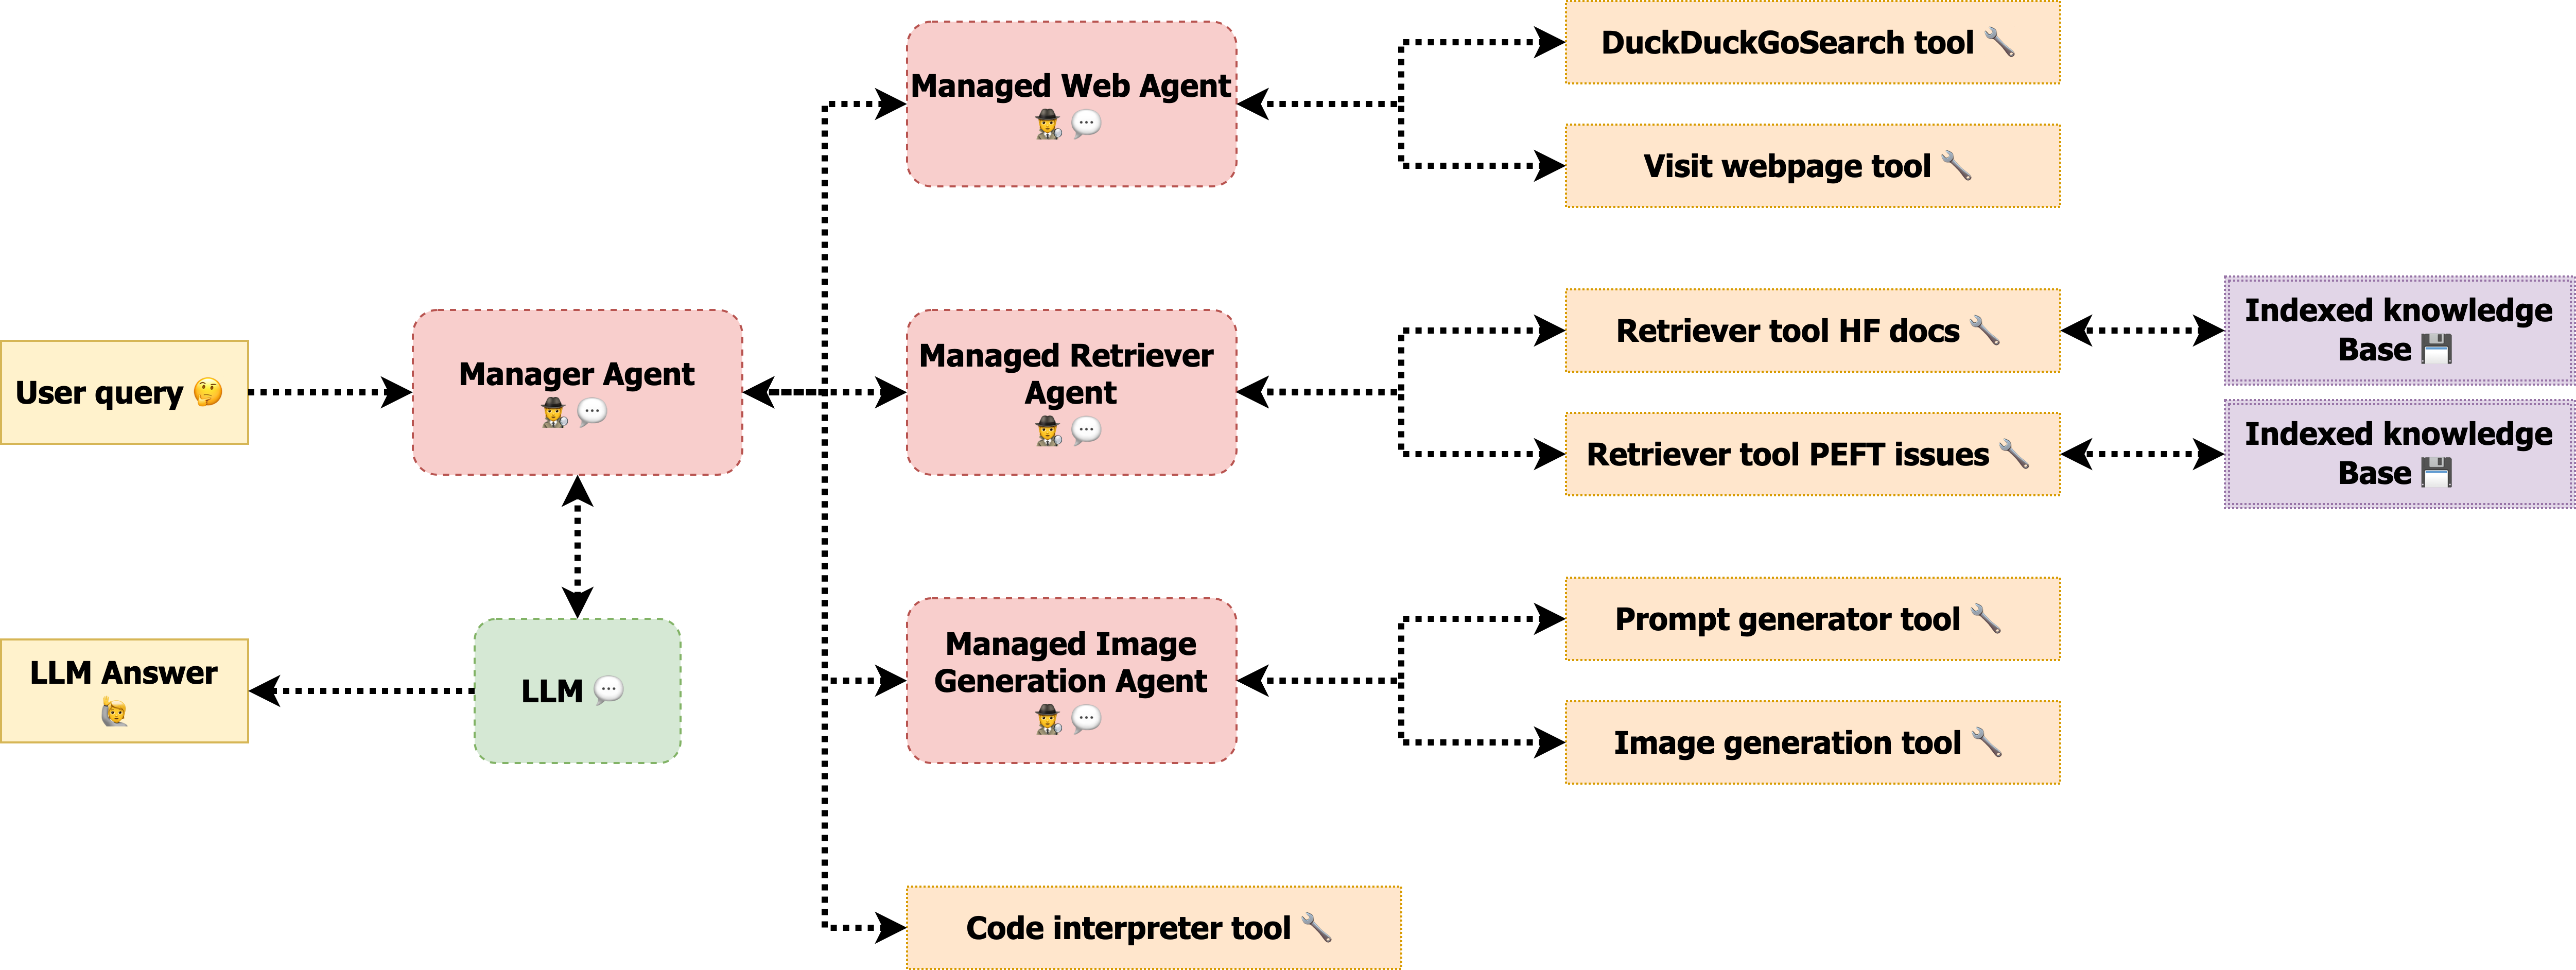

# 1. Install dependencies

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git#egg=transformers[agents]

In [ ]:
!pip install markdownify duckduckgo-search spaces gradio-tools langchain langchain-community faiss-cpu --upgrade -q

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# 2. Let's create out RAG agents

## 2.1 Web search agent 🔍

[`DuckDuckGoSearchTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py)

In [5]:
import re
import requests
from markdownify import markdownify as md
from requests.exceptions import RequestException
from transformers.agents import tool


@tool
def visit_webpage(url: str) -> str:
    """Visits a webpage at the given URL and returns its content as a markdown string.

    Args:
        url: The URL of the webpage to visit.

    Returns:
        The content of the webpage converted to Markdown, or an error message if the request fails.
    """
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Convert the HTML content to Markdown
        markdown_content = md(response.text).strip()

        # Remove multiple line breaks
        markdown_content = re.sub(r"\n{3,}", "\n\n", markdown_content)

        return markdown_content

    except RequestException as e:
        return f"Error fetching the webpage: {str(e)}"
    except Exception as e:
        return f"An unexpected error occurred: {str(e)}"

### 2.1.1 Build our multi-agent system 🤖🤝🤖

`ReactJsonAgent`.

In [53]:
from transformers.agents import (
    ReactCodeAgent,
    ReactJsonAgent,
    HfApiEngine,
    ManagedAgent,
)
from transformers.agents.search import DuckDuckGoSearchTool

model = "Qwen/Qwen2.5-72B-Instruct"
llm_engine = HfApiEngine(model)

web_agent = ReactJsonAgent(
    tools=[DuckDuckGoSearchTool(), visit_webpage],
    llm_engine=llm_engine,
    max_iterations=10,
)

`ManagedAgent`

In [7]:
managed_web_agent = ManagedAgent(
    agent=web_agent,
    name="search",
    description="Runs web searches for you. Give it your query as an argument.",
)

`managed_agents`  `ReactCodeAgent` `additional_authorized_imports=["time", "datetime"]`

## 2.2 Retriever agent

### 2.2.1 HF docs retriever tool

In [ ]:
import datasets

knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    AutoTokenizer.from_pretrained("thenlper/gte-small"),
    chunk_size=200,
    chunk_overlap=20,
    add_start_index=True,
    strip_whitespace=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

# Split docs and keep only unique ones
print("Splitting documents...")
docs_processed = []
unique_texts = {}
for doc in tqdm(source_docs):
    new_docs = text_splitter.split_documents([doc])
    for new_doc in new_docs:
        if new_doc.page_content not in unique_texts:
            unique_texts[new_doc.page_content] = True
            docs_processed.append(new_doc)

print(
    "Embedding documents... This should take a few minutes (5 minutes on MacBook with M1 Pro)"
)
embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")
vectordb = FAISS.from_documents(
    documents=docs_processed,
    embedding=embedding_model,
    distance_strategy=DistanceStrategy.COSINE,
)

In [10]:
from transformers.agents import Tool
from langchain_core.vectorstores import VectorStore


class RetrieverTool(Tool):
    name = "retriever"
    description = "Using semantic similarity, retrieves some documents from the knowledge base that have the closest embeddings to the input query."
    inputs = {
        "query": {
            "type": "string",
            "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
        }
    }
    output_type = "string"

    def __init__(self, vectordb: VectorStore, **kwargs):
        super().__init__(**kwargs)
        self.vectordb = vectordb

    def forward(self, query: str) -> str:
        assert isinstance(query, str), "Your search query must be a string"

        docs = self.vectordb.similarity_search(
            query,
            k=7,
        )

        return "\nRetrieved documents:\n" + "".join(
            [
                f"===== Document {str(i)} =====\n" + doc.page_content
                for i, doc in enumerate(docs)
            ]
        )

In [11]:
from transformers.agents import HfApiEngine, ReactJsonAgent


retriever_tool = RetrieverTool(vectordb)
retriever_agent = ReactJsonAgent(
    tools=[retriever_tool], llm_engine=llm_engine, max_iterations=4, verbose=2
)

### 2.2.2 PEFT issues retriever tool

In [12]:
from getpass import getpass

ACCESS_TOKEN = getpass("YOUR_GITHUB_PERSONAL_TOKEN")

YOUR_GITHUB_PERSONAL_TOKEN··········


In [13]:
from langchain.document_loaders import GitHubIssuesLoader

loader = GitHubIssuesLoader(repo="huggingface/peft", access_token=ACCESS_TOKEN, include_prs=False, state="all")

docs = loader.load()

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=30)

chunked_docs = splitter.split_documents(docs)

In [ ]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

db = FAISS.from_documents(chunked_docs, HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5"))

In [16]:
from transformers.agents import HfApiEngine, ReactJsonAgent

retriever_issues_tool = RetrieverTool(db)

### 2.2.3 Build the Retriever agent

In [17]:
retriever_agent = ReactJsonAgent(
    tools=[retriever_tool, retriever_issues_tool], llm_engine=llm_engine, max_iterations=4, verbose=2
)

In [18]:
managed_retriever_agent = ManagedAgent(
    agent=retriever_agent,
    name="retriever",
    description="Retrieves documents from the knowledge base for you that are close to the input query. Give it your query as an argument.",
)

## 2.3 Image generation agent




In [19]:
from gradio_tools import StableDiffusionPromptGeneratorTool
from transformers import Tool, load_tool, CodeAgent

gradio_prompt_generator_tool = StableDiffusionPromptGeneratorTool()
prompt_generator_tool = Tool.from_gradio(gradio_prompt_generator_tool)

Loaded as API: https://microsoft-promptist.hf.space ✔


In [47]:
image_generation_tool = load_tool("m-ric/text-to-image", cache=False)
image_generation_agent = CodeAgent(tools=[prompt_generator_tool, image_generation_tool], llm_engine=llm_engine)

In [48]:
managed_image_generation_agent = ManagedAgent(
    agent=image_generation_agent,
    name="image_generation",
    description="Generates images from text prompts. Give it your prompt as an argument.",
)

# 3. Let's add the general agent manager to orchestate the system.

In [54]:
manager_agent = ReactCodeAgent(
    tools=[],
    llm_engine=llm_engine,
    managed_agents=[managed_web_agent, managed_retriever_agent, managed_image_generation_agent],
    additional_authorized_imports=["time", "datetime"],
)

In [24]:
manager_agent.run("How many years ago was Stripe founded?")

======== New task ========
How many years ago was Stripe founded?
=== Agent thoughts:
Thought: To solve this task, I need to find out the year when Stripe was founded and then calculate the difference between the current year and the founding year. I will use the `search` tool to find the founding year of Stripe.
>>> Agent is executing the code below:
founding_year = search("When was Stripe founded")
print("Founding Year:", founding_year)
====
======== New task ========
You're a helpful agent named 'search'.
You have been submitted this task by your manager.
---
Task:
When was Stripe founded
---
You're helping your manager solve a wider task: so make sure to not provide a one-line answer, but give as much information as possible so that they have a clear understanding of the answer.

Your final_answer WILL HAVE to contain these parts:
### 1. Task outcome (short version):
### 2. Task outcome (extremely detailed version):
### 3. Additional context (if relevant):

Put all these in your fi

14

In [ ]:
#result = manager_agent.run(
#    "Improve this prompt, then generate an image of it and give the user the image location as task outcome", prompt='A rabbit wearing a space suit'
#)

result = manager_agent.run(
    "Improve this prompt, then generate an image of it.", prompt='A rabbit wearing a space suit'
)

In [54]:
result

'/tmp/tmphaoatb8t/85d6d0a3-9441-4a60-80f0-daa12472ad74.png'

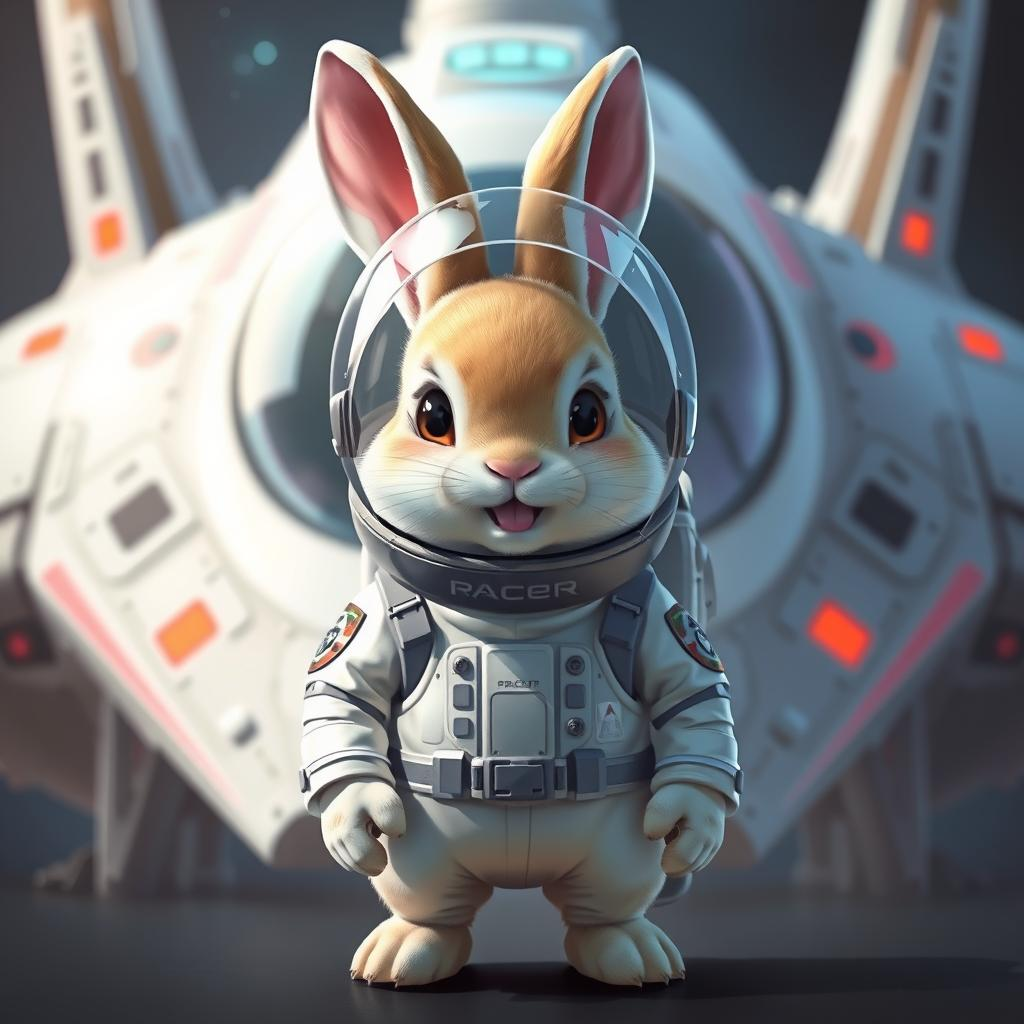

In [56]:
from IPython.display import Image, display

display(Image(filename=result))

In [28]:
manager_agent.run("How can I push a model to the Hub?")

======== New task ========
How can I push a model to the Hub?
=== Agent thoughts:
Thought: The task is asking for guidance on how to push a model to the Hub, which suggests it's referring to the Hugging Face Model Hub, a repository for sharing and discovering machine learning models. However, to provide a more detailed answer, I'll need to search for a step-by-step guide on how to do this.
>>> Agent is executing the code below:
# I will request the search team member to provide a step-by-step guide on how to push a model to the Hub.
search_result = search(query="How to push a model to the Hugging Face Model Hub")
print(search_result)
====
Code execution failed due to the following error:
ManagedAgent.__call__() missing 1 required positional argument: 'request'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/agents.py", line 1135, in step
    result = self.python_evaluator(
  File "/usr/local/lib/python3.10/dist-packages/transformer

'\nTo push a model to the Hugging Face Model Hub, follow these steps:\n1. Authenticate: Create an account, generate an access token, and install the Hugging Face Hub Library.\n2. Prepare the model: Save the model and tokenizer in a compatible format.\n3. Push to the Hub: Create a new repository, add a model card (optional), and push the model to the repository.\n'

In [29]:
manager_agent.run("How do you combine multiple adapters in peft?")

======== New task ========
How do you combine multiple adapters in peft?
=== Agent thoughts:
Thought: I need to find out how to combine multiple adapters in PEFT. I will use the `retriever` tool to search for a relevant document in the knowledge base.
>>> Agent is executing the code below:
document = retriever(query="PEFT combining multiple adapters")
print(document)
====
Code execution failed due to the following error:
ManagedAgent.__call__() missing 1 required positional argument: 'request'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/agents.py", line 1135, in step
    result = self.python_evaluator(
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/python_interpreter.py", line 902, in evaluate_python_code
    result = evaluate_ast(node, state, static_tools, custom_tools, authorized_imports)
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/python_interpreter.py", line 741, in evaluate_ast


'It is possible to use multiple adapters of the same type in PEFT, but combining adapters of different types is not allowed. However, using multiple adapters may lead to unintended behavior and losing progress, and should be carefully evaluated.'